### 🎯 Unlearning by Confusing Layers
Vamos a entrenar un ensablado de modelos ResNet18 y evaluar la eficacia de un MIA cuando reentrenamos los modelos partiendo de un modelo base con ciertas capas _confundidas_. Estudiamos primero el caso de un único modelo reentrenado.

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn import linear_model, model_selection
import pickle

# Suppress warnings and TensorFlow logs
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, metrics
from tensorflow.keras.utils import split_dataset
from tensorflow.python.client import device_lib

import keras_cv as kcv
from keras_cv import visualization
from keras_cv.models import ResNet18Backbone

Using TensorFlow backend


In [2]:
def set_device(mixed_precision=True, set_jit=False):
    # printed out the detected devices
    list_ld = device_lib.list_local_devices()
    for dev in list_ld:
        print(dev.name,dev.memory_limit)

    # get the lisf of physical devices
    physical_devices = tf.config.list_physical_devices(
        'GPU' if len(list_ld) - 1 else 'CPU'
    )
    # For GPU devices, configure related stuff
    if 'GPU' in physical_devices[-1]:
        tf.config.optimizer.set_jit(set_jit)
        if mixed_precision:
            keras.mixed_precision.set_global_policy(
                "mixed_float16"
            )
        else:
            keras.mixed_precision.set_global_policy(
                keras.backend.floatx()
            )
        for pd in physical_devices:
            tf.config.experimental.set_memory_growth(
                pd, True
            )
    strategy = tf.distribute.MirroredStrategy()
    return (strategy, physical_devices)

In [3]:
strategy, physical_devices = set_device(mixed_precision=True, set_jit=True)
physical_devices, strategy, tf.__version__

/device:CPU:0 268435456
/device:GPU:0 4254072832
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')],
 '2.15.1')

___
Descargamos y preparamos los datos de CIFAR-10.

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 128

(x_train, y_train), held_out = keras.datasets.cifar10.load_data()
test_set, val_set = split_dataset(held_out, left_size=0.2)

In [5]:
def normalize(image, label, denorm=False):
    rescale = keras.layers.Rescaling(scale=1./255.)
    norms = keras.layers.Normalization(
        mean=[0.4914, 0.4822, 0.4465],
        variance=[np.square(0.2023), np.square(0.1994), np.square(0.2010)],
        invert=denorm,
        axis=-1,
    )

    if not denorm:
        image = rescale(image)
    return norms(image), label

In [6]:
# Esta función divide el conjunto de datos (no convertidos en un Dataset) en 'S' trozos de igual tamaño,
# proporcionando también los conjuntos a olvidar y retener

def sliced_ds_raw(x,y,S):
    x_slices = []
    y_slices = []
    ft_set_x=[]
    ft_set_y=[]
    rt_set_x=[]
    rt_set_y=[]

    # Calculate the size of each slice
    slice_size = x.shape[0] // S
    forget_size = slice_size // 10

    for i in range(S):
        start_index = i * slice_size
        end_index = start_index + slice_size
        x_slices.append(x[start_index:end_index])
        y_slices.append(y[start_index:end_index])
        ft_set_x.append(x[start_index:start_index+forget_size])
        ft_set_y.append(y[start_index:start_index+forget_size])
        rt_set_x.append(x[start_index+forget_size:end_index])
        rt_set_y.append(y[start_index+forget_size:end_index])

    return x_slices, y_slices, ft_set_x, ft_set_y, rt_set_x, rt_set_y

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_ds = train_ds.map(normalize)
train_ds = train_ds.shuffle(buffer_size=8*BATCH_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = val_set.map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_set.map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [8]:
forget_set, retain_set = keras.utils.split_dataset(train_ds.unbatch(), left_size=0.1)
forget_ds = forget_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
retain_ds = retain_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
print('A olvidar:', int(forget_set.cardinality()),', a retener:', int(retain_set.cardinality()))

A olvidar: 5000 , a retener: 45000


___
Descargamos el modelo ResNet18, y lo entrenamos habiendo reinicializado ciertas capas.

In [9]:
def get_model():
    with strategy.scope():
        model = keras.Sequential(
            [
                ResNet18Backbone(include_rescaling=False, input_shape=(32, 32, 3)),
                keras.layers.GlobalMaxPooling2D(),
                keras.layers.Dense(10, activation="softmax", dtype=tf.float32),
            ]
        )
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=metrics.SparseCategoricalAccuracy(name='accuracy'),
            jit_compile=True
        )

    return model

In [10]:
model = keras.saving.load_model('resnet18_cifar10.keras')
for layer in model.layers:
    layer._name=layer.name.removesuffix('_full') 
model.summary(expand_nested=True)

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_net_backbone (ResNetBa  (None, 1, 1, 512)         11186112  
 ckbone)                                                         
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)       [(None, 32, 32, 3)]       0        |
|                                                               |
| conv1_conv (Conv2D)        (None, 16, 16, 64)        9408     |
|                                                               |
| conv1_bn (BatchNormalizat  (None, 16, 16, 64)        256      |
| ion)                                                          |
|                                                               |
| conv1_relu (Activation)    (None, 16, 16, 64)        0        |
|                                                               |
| pool1_pool (MaxPooling2D)  (None, 8, 8, 64)          0

In [11]:
# Análisis de la exactitud en el conjunto de datos
print(f"Train set accuracy: {100.0 * model.evaluate(train_ds)[-1]:0.1f}%%")
print(f"Retain set accuracy: {100.0 * model.evaluate(retain_ds)[-1]:0.1f}%%")
print(f"Forget set accuracy: {100.0 * model.evaluate(forget_ds)[-1]:0.1f}%%")
print(f"Test set accuracy: {100.0 * model.evaluate(test_ds)[-1]:0.1f}%%")

 22/391 [>.............................] - ETA: 2s - loss: 0.0919 - accuracy: 0.9688 

I0000 00:00:1718288931.399543  147541 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 [==============================] - 25s 32ms/step - loss: 0.0923 - accuracy: 0.9690
Train set accuracy: 96.9%%
352/352 [==============================] - 13s 37ms/step - loss: 0.0911 - accuracy: 0.9696
Retain set accuracy: 97.0%%
40/40 [==============================] - 10s 244ms/step - loss: 0.1032 - accuracy: 0.9640
Forget set accuracy: 96.4%%
16/16 [==============================] - 0s 9ms/step - loss: 1.3440 - accuracy: 0.7450
Test set accuracy: 74.5%%


___
Reinicialización de capas.

In [11]:
# Function to reinitialize specific layer weights using their original initializers
def reinitialize_layer_weights(layer):
    if hasattr(layer, 'kernel_initializer'):
        # Reinitialize kernel using its initializer
        new_weights = layer.kernel_initializer(layer.kernel.shape)
        if hasattr(layer, 'bias') and layer.bias is not None:
            # Reinitialize bias if it exists
            new_biases = layer.bias_initializer(layer.bias.shape)
            layer.set_weights([new_weights, new_biases])
        else:
            layer.set_weights([new_weights])
        print(f"Layer '{layer.name}' weights reinitialized.")
    elif hasattr(layer, 'layers'):
        # Recursively apply to nested layers
        for nested_layer in layer.layers:
            reinitialize_layer_weights(nested_layer)
    else:
        print(f"Layer '{layer.name}' does not have initializers or nested layers.")

# Function to find and reinitialize a specific layer by name
def reinitialize_named_layer_weights(model, layer_name):
    for layer in model.layers:
        if layer.name == layer_name:
            reinitialize_layer_weights(layer)
            return
        elif hasattr(layer, 'layers'):
            for nested_layer in layer.layers:
                if nested_layer.name == layer_name:
                    reinitialize_layer_weights(nested_layer)
                    return

In [ ]:
reinitialize_named_layer_weights(unlearn_model, 'dense')

# reinitialize_named_layer_weights(unlearn_model, 'conv1_conv')
# reinitialize_named_layer_weights(unlearn_model, 'v2_stack_3_block1_2_conv')

___
Confusión de capas.

In [12]:
from keras.layers import Conv2D

def vision_confuser(model, std=0.1):
    # Assuming the ResNet18 backbone is the first layer of the model
    resnet_backbone = model.layers[0]
    for layer in resnet_backbone.layers:
        if isinstance(layer, Conv2D):
            weights = layer.get_weights()
            # Iterate over each array in the list
            for i, arr in enumerate(weights):
                # Generate random numbers from a normal distribution
                random_numbers = np.random.normal(0, std, size=arr.shape)
                # Add the random numbers to the original array
                weights[i] += random_numbers
            layer.set_weights(weights)

    weights = model.layers[-1].get_weights()
    # Iterate over each array in the list
    for i, arr in enumerate(weights):
        # Generate random numbers from a normal distribution
        random_numbers = np.random.normal(0, std, size=arr.shape)
        # Add the random numbers to the original array
        weights[i] += random_numbers
    model.layers[-1].set_weights(weights)


In [28]:
unlearn_model = tf.keras.models.clone_model(model)
unlearn_model.set_weights(model.get_weights())
unlearn_model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=metrics.SparseCategoricalAccuracy(name='accuracy'),
        jit_compile=True
    )

In [22]:
confusion_std=0.1

vision_confuser(unlearn_model, std=confusion_std)

In [20]:
def compare_weights(model1,model2):
    # Extract the 'res_net_backbone' layer
    res_net_backbone = model1.get_layer('res_net_backbone')
    backbone_layer_weights = [layer.get_weights() for layer in res_net_backbone.layers if layer.count_params() > 0 and not layer.name.endswith('_bn')]

    # Extract layer names and weights for the entire model
    layer_names = [layer.name for layer in model1.layers]
    layer_weights = [layer.get_weights() for layer in model1.layers]

    model1_weights = []

    for name, weights in zip(layer_names, layer_weights):
        if name == 'res_net_backbone':
            model1_weights.extend(backbone_layer_weights)
        elif weights:  # Only add layers that have weights
            model1_weights.append(weights)

        # Extract the 'res_net_backbone' layer
    res_net_backbone = model2.get_layer('res_net_backbone')
    backbone_layer_weights = [layer.get_weights() for layer in res_net_backbone.layers if layer.count_params() > 0 and not layer.name.endswith('_bn')]

    # Extract layer names and weights for the entire model
    layer_names = [layer.name for layer in model2.layers]
    layer_weights = [layer.get_weights() for layer in model2.layers]

    model2_weights = []

    for name, weights in zip(layer_names, layer_weights):
        if name == 'res_net_backbone':
            model2_weights.extend(backbone_layer_weights)
        elif weights:  # Only add layers that have weights
            model2_weights.append(weights)

    layer_names=['conv1','0_1_1_conv','0_1_2_conv','0_2_1_conv',
    '0_2_2_conv','1_1_1_conv','1_1_0_conv','1_1_2_conv','1_2_1_conv',
    '1_2_2_conv','2_1_1_conv','2_1_0_conv','2_1_2_conv','2_2_1_conv',
    '2_2_2_conv','3_1_1_conv','3_1_0_conv','3_1_2_conv','3_2_1_conv',
    '3_2_2_conv','dense_out']

    return layer_names, model1_weights, model2_weights

In [14]:
from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt

def flatten_arrays(arrays):
    flattened_elements = []
    for arr in arrays:
        flattened_elements.extend(arr.flatten())
    return flattened_elements

def cos_sim(a,b):
    return dot(a, b)/(norm(a)*norm(b))

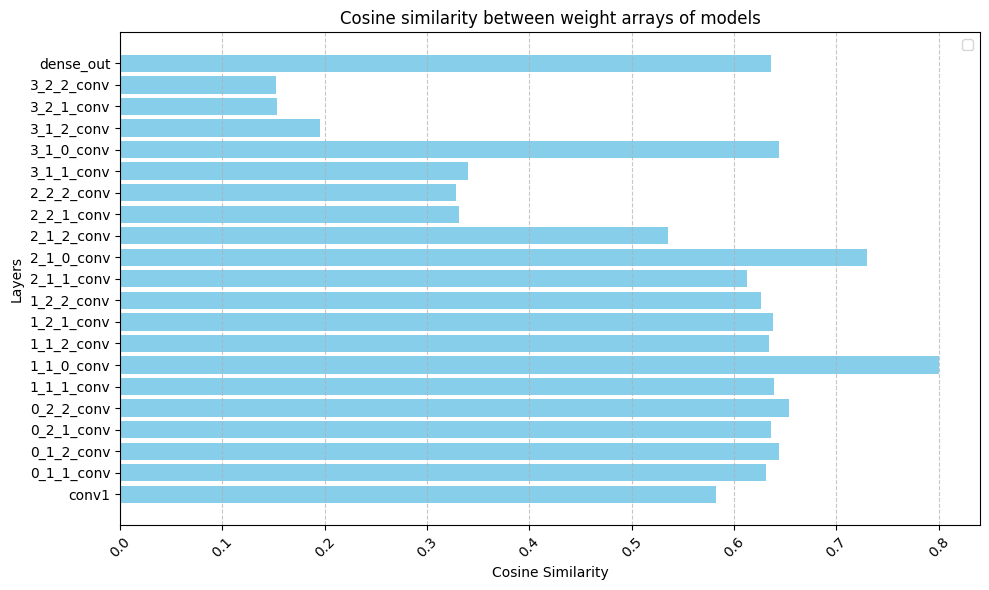

In [30]:
layer_names, model1_wights, model2_weghts = compare_weights(model,unlearn_model)

# Initialize list to store cosine similarities
similarities = []

# Compute cosine similarity for each layer
for w1, w2 in zip(model1_wights, model2_weghts):
    w1=flatten_arrays(w1)
    w2=flatten_arrays(w2)
    similarity = cos_sim(w1, w2)
    similarities.append(similarity)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(layer_names, similarities, color='skyblue', capsize=5)
plt.xlabel('Cosine Similarity')
plt.ylabel('Layers')
plt.title('Cosine similarity between weight arrays of models')
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend()

plt.show()

___
_Fine-tuning_ y análisis del modelo resultante

In [21]:
unlearn_model.fit(retain_ds, validation_data=val_ds, epochs=1)

vision_confuser(unlearn_model, std=confusion_std)
unlearn_model.fit(retain_ds, validation_data=val_ds, epochs=1)

vision_confuser(unlearn_model, std=confusion_std)
unlearn_model.fit(retain_ds, validation_data=val_ds, epochs=1)

vision_confuser(unlearn_model, std=confusion_std)
unlearn_model.fit(retain_ds, validation_data=val_ds, epochs=1)

vision_confuser(unlearn_model, std=confusion_std)
unlearn_model.fit(retain_ds, validation_data=val_ds, epochs=2)

vision_confuser(unlearn_model, std=confusion_std)
unlearn_model.fit(retain_ds, validation_data=val_ds, epochs=4)

352/352 [==============================] - 6s 17ms/step - loss: 1.6589 - accuracy: 0.4371 - val_loss: 1.4934 - val_accuracy: 0.4801
Epoch 1/2
352/352 [==============================] - 6s 16ms/step - loss: 1.5975 - accuracy: 0.4488 - val_loss: 1.3939 - val_accuracy: 0.4999
Epoch 2/2
352/352 [==============================] - 6s 16ms/step - loss: 1.2488 - accuracy: 0.5558 - val_loss: 1.3330 - val_accuracy: 0.5364
Epoch 1/4
352/352 [==============================] - 6s 17ms/step - loss: 1.4973 - accuracy: 0.4927 - val_loss: 1.3780 - val_accuracy: 0.5186
Epoch 2/4
352/352 [==============================] - 6s 16ms/step - loss: 1.1568 - accuracy: 0.5937 - val_loss: 1.3871 - val_accuracy: 0.5421
Epoch 3/4
352/352 [==============================] - 6s 17ms/step - loss: 0.9702 - accuracy: 0.6629 - val_loss: 1.2617 - val_accuracy: 0.5735
Epoch 4/4
352/352 [==============================] - 6s 17ms/step - loss: 0.7678 - accuracy: 0.7409 - val_loss: 1.3516 - val_accuracy: 0.5665


  3/352 [..............................] - ETA: 23s - loss: 3.5420 - accuracy: 0.3828   

W0000 00:00:1718290539.257952  147539 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


40/40 [==============================] - 0s 8ms/step - loss: 2.5497 - accuracy: 0.3050
Epoch 1/2
352/352 [==============================] - 7s 21ms/step - loss: 0.8402 - accuracy: 0.7065 - val_loss: 0.8849 - val_accuracy: 0.7001
Epoch 2/2
40/40 [==============================] - 0s 7ms/step - loss: 3.2635 - accuracy: 0.3200
Epoch 1/4
352/352 [==============================] - 7s 21ms/step - loss: 0.7553 - accuracy: 0.7343 - val_loss: 0.9190 - val_accuracy: 0.6976
Epoch 2/4
352/352 [==============================] - 7s 19ms/step - loss: 0.3932 - accuracy: 0.8643 - val_loss: 1.1440 - val_accuracy: 0.6796
Epoch 3/4
352/352 [==============================] - 8s 21ms/step - loss: 0.2071 - accuracy: 0.9314 - val_loss: 1.5017 - val_accuracy: 0.6694
Epoch 4/4
352/352 [==============================] - 7s 20ms/step - loss: 0.1697 - accuracy: 0.9403 - val_loss: 1.5668 - val_accuracy: 0.6636


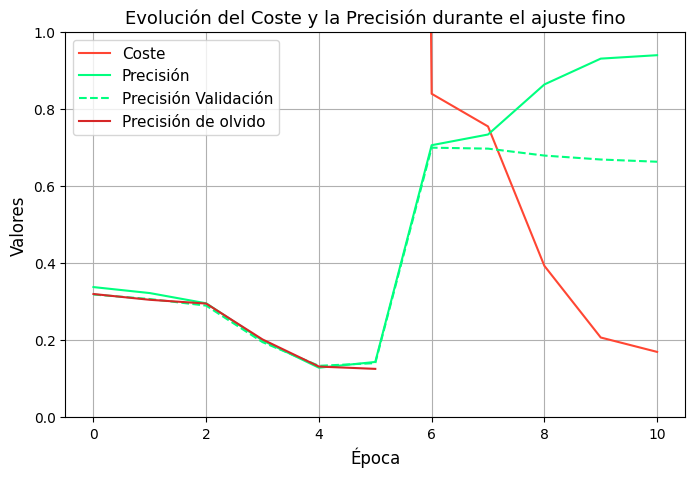

In [29]:
# Inicializar un DataFrame vacío
grafica = pd.DataFrame()
for key in ['loss', 'accuracy', 'val_accuracy', 'forget_accuracy']:
    if key not in grafica.columns:
        grafica[key] = pd.Series(dtype=float)

# Lista de epochs para cada sesión de entrenamiento
epochs_list = [1, 1, 1, 1, 2, 4]

# Simulando el proceso de entrenamiento y acumulación de datos
for epochs in epochs_list:
    # Añadir los valores después de usar vision_confuser
    vision_confuser(unlearn_model, std=confusion_std)
    
    valores = {'loss': unlearn_model.evaluate(retain_ds)[-2], 'accuracy': unlearn_model.evaluate(retain_ds)[-1], 'val_accuracy': unlearn_model.evaluate(val_ds)[-1], 'forget_accuracy': unlearn_model.evaluate(forget_ds)[-1]}
    for key, value in valores.items():
        grafica[key] = pd.concat([pd.Series([value]), grafica[key]]).reset_index(drop=True)
    
    # Entrenar el modelo
    history = unlearn_model.fit(retain_ds, validation_data=val_ds, epochs=epochs)
    
    # Convertir los datos de la historia en un DataFrame
    session_data = pd.DataFrame(history.history)
    
    # Acumular los datos
    grafica = pd.concat([grafica, session_data], ignore_index=True)
    
    

# Eliminar la columna de 'val_loss' si existe
if 'val_loss' in grafica.columns:
    grafica = grafica.drop(columns=['val_loss'])

# Graficar el DataFrame acumulado
grafica.plot(figsize=(8, 5))

# Configurar propiedades del gráfico
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Valores', fontsize=12)

# Cambiar colores y estilos de líneas
plt.gca().get_lines()[0].set_color('#ff4633')  # 'loss'
plt.gca().get_lines()[1].set_color('springgreen')  # 'accuracy'
plt.gca().get_lines()[2].set_color('springgreen')  # 'val_accuracy'
plt.gca().get_lines()[2].set_linestyle('--')

plt.legend(['Coste', 'Precisión', 'Precisión Validación', 'Precisión de olvido'], fontsize=11)
plt.title('Evolución del Coste y la Precisión durante el ajuste fino', fontsize=13)

plt.show()

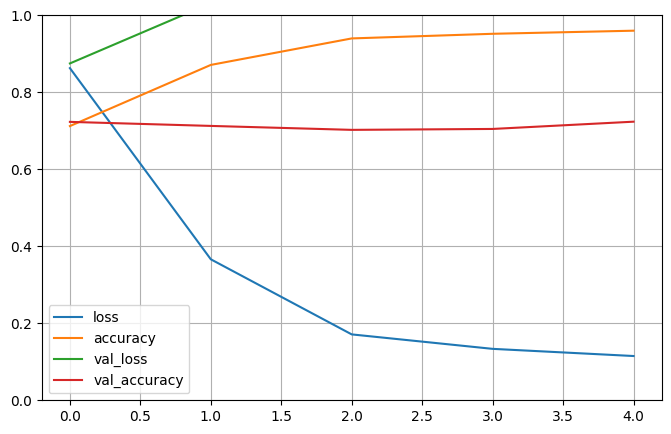

In [46]:
# Análisis del entrenamiento y el modelo

pd.DataFrame(unlearn_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

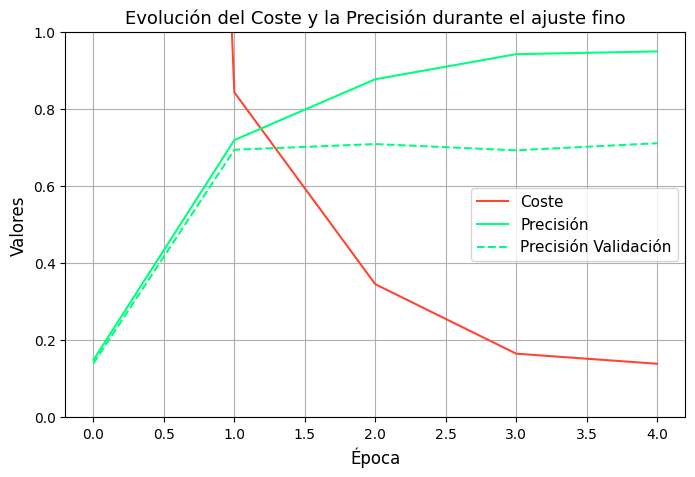

In [20]:
# Asumiendo que 'history.history' es un diccionario con los datos del entrenamiento
grafica = pd.DataFrame(unlearn_history.history)

# Eliminar la columna de 'val_loss' (coste de validación)
grafica = grafica.drop(columns=['val_loss'])

# Ejemplo: añadir 0 para cada columna en la primera posición
valores_iniciales = {'loss': 9.8437, 'accuracy': 0.1487, 'val_accuracy': 0.1399}
for key, value in valores_iniciales.items():
    grafica[key] = pd.concat([pd.Series([value]), grafica[key]]).reset_index(drop=True)

# Graficar el DataFrame
grafica.plot(figsize=(8,5))

# Configurar propiedades
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Valores', fontsize=12)

# Cambiar colores y estilos de líneas
plt.gca().get_lines()[0].set_color('#ff4633')
plt.gca().get_lines()[1].set_color('springgreen')
plt.gca().get_lines()[2].set_color('springgreen')

plt.gca().get_lines()[2].set_linestyle('--')

plt.legend(['Coste', 'Precisión', 'Precisión Validación'], fontsize=11)
plt.title('Evolución del Coste y la Precisión durante el ajuste fino', fontsize=13)

plt.show()

In [19]:
# Análisis de la exactitud en el conjunto de datos
print(f"Train set accuracy: {100.0 * unlearn_model.evaluate(train_ds)[-1]:0.1f}%%")
print(f"Retain set accuracy: {100.0 * unlearn_model.evaluate(retain_ds)[-1]:0.1f}%%")
print(f"Forget set accuracy: {100.0 * unlearn_model.evaluate(forget_ds)[-1]:0.1f}%%")
print(f"Validation set accuracy: {100.0 * unlearn_model.evaluate(val_ds)[-1]:0.1f}%%")
print(f"Test set accuracy: {100.0 * unlearn_model.evaluate(test_ds)[-1]:0.1f}%%")

391/391 [==============================] - 7s 12ms/step - loss: 9.8438 - accuracy: 0.1490
Train set accuracy: 14.9%%
352/352 [==============================] - 4s 13ms/step - loss: 9.8437 - accuracy: 0.1487
Retain set accuracy: 14.9%%
40/40 [==============================] - 1s 34ms/step - loss: 9.8446 - accuracy: 0.1516
Forget set accuracy: 15.2%%
63/63 [==============================] - 2s 30ms/step - loss: 9.9363 - accuracy: 0.1399
Validation set accuracy: 14.0%%
16/16 [==============================] - 0s 9ms/step - loss: 10.0222 - accuracy: 0.1435
Test set accuracy: 14.4%%


___
Cuantificamos la calidad del algoritmo de desaprendizaje a través de un _membership inference attack_ simple (MIA).

Este MIA consiste en un modelo de regresión logística que predice si el modelo fue entrenado en una muestra particular a partir del _loss_ de esa muestra. Para tener una idea de la dificultad de este problema, primero graficamos a continuación un histograma de los _loss_-es del modelo preentrenado en el conjunto de entrenamiento y prueba.

In [13]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    loss_fn = keras.losses.SparseCategoricalCrossentropy(
        reduction="none"
    )
    all_losses = []

    for inputs, targets in tqdm(loader):
        logits = net(inputs, training=False)
        losses = loss_fn(targets, logits).numpy()
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

In [14]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

In [22]:
test_losses = compute_losses(unlearn_model, test_ds)
forget_losses = compute_losses(unlearn_model, forget_ds)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(forget_losses)
forget_losses = forget_losses[:len(test_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA attack has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

100%|██████████| 40/40 [00:02<00:00, 14.12it/s]

The MIA attack has an accuracy of 0.492 on forgotten vs unseen images


In [23]:
# Getting back the objects:
with open('UnConLa_cycles.pkl', 'rb') as f:
    [confusion_stds, accuracy_retain, accuracy_forget, accuracy_test, mia_score] = pickle.load(f)

confusion_stds[2].append(confusion_std)
accuracy_retain[2].append(unlearn_model.evaluate(retain_ds)[-1])
accuracy_forget[2].append(unlearn_model.evaluate(forget_ds)[-1])
accuracy_test[2].append(unlearn_model.evaluate(test_ds)[-1])
mia_score[2].append(mia_scores.mean())

# Saving the objects:
with open('UnConLa_cycles.pkl', 'wb') as f:
    pickle.dump([confusion_stds, accuracy_retain, accuracy_forget, accuracy_test, mia_score], f)

16/16 [==============================] - 1s 85ms/step - loss: 1.3497 - accuracy: 0.5730


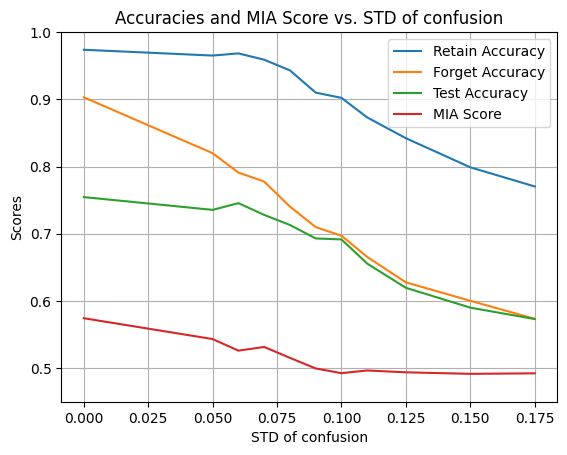

In [24]:
plt.plot(confusion_stds[2], accuracy_retain[2], label='Retain Accuracy')
plt.plot(confusion_stds[2], accuracy_forget[2], label='Forget Accuracy')
plt.plot(confusion_stds[2], accuracy_test[2], label='Test Accuracy')
plt.plot(confusion_stds[2], mia_score[2], label='MIA Score')

plt.xlabel('STD of confusion')
plt.ylabel('Scores')
plt.title('Accuracies and MIA Score vs. STD of confusion')
plt.legend()
plt.grid(True)
plt.gca().set_ylim(0.45,1)
plt.show()

In [25]:
confusion_stds

[[0.0, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.125, 0.15, 0.175],
 [0.0, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.125, 0.15, 0.175],
 [0.0, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.125, 0.15, 0.175]]

In [127]:
# Getting back the objects:
with open('UnConLa.pkl', 'rb') as f:
    [confusion_stds, accuracy_retain, accuracy_forget, accuracy_test, mia_score] = pickle.load(f)

confusion_stds[2].append(confusion_std)
accuracy_retain[2].append(unlearn_model.evaluate(retain_ds)[-1])
accuracy_forget[2].append(unlearn_model.evaluate(forget_ds)[-1])
accuracy_test[2].append(unlearn_model.evaluate(test_ds)[-1])
mia_score[2].append(mia_scores.mean())

# Saving the objects:
with open('UnConLa.pkl', 'wb') as f:
    pickle.dump([confusion_stds, accuracy_retain, accuracy_forget, accuracy_test, mia_score], f)

16/16 [==============================] - 1s 80ms/step - loss: 2.0502 - accuracy: 0.6370


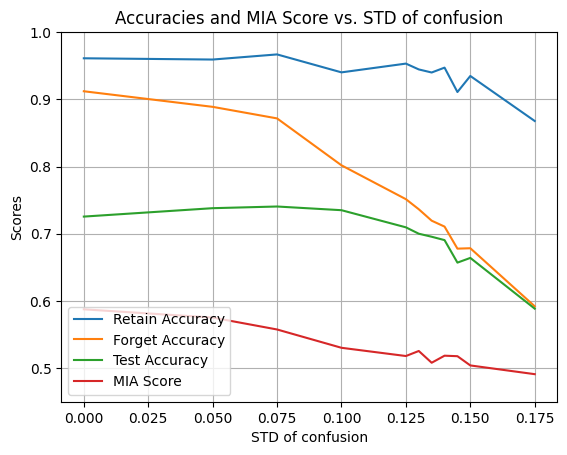

In [164]:
plt.plot(confusion_stds[0], accuracy_retain[0], label='Retain Accuracy')
plt.plot(confusion_stds[0], accuracy_forget[0], label='Forget Accuracy')
plt.plot(confusion_stds[0], accuracy_test[0], label='Test Accuracy')
plt.plot(confusion_stds[0], mia_score[0], label='MIA Score')

plt.xlabel('STD of confusion')
plt.ylabel('Scores')
plt.title('Accuracies and MIA Score vs. STD of confusion')
plt.legend()
plt.grid(True)
plt.gca().set_ylim(0.45,1)
plt.show()

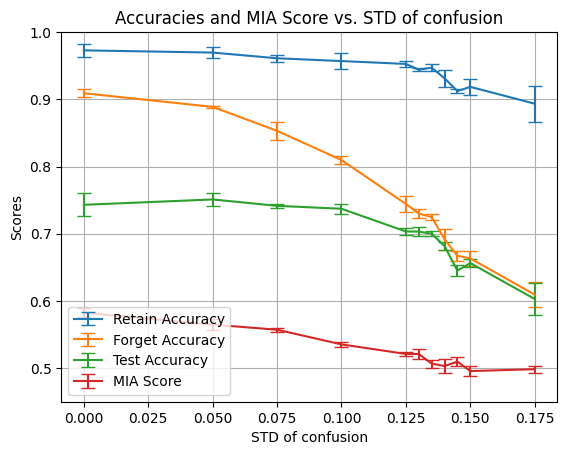

In [167]:
# Convert to numpy arrays
accuracy_retain = np.array(accuracy_retain)
accuracy_forget = np.array(accuracy_forget)
accuracy_test = np.array(accuracy_test)
mia_score = np.array(mia_score)
confusion_stds = np.array(confusion_stds[0])  # Confusion STDs are the same for all three, so just take one

# Calculate means and standard deviations
retain_mean = np.mean(accuracy_retain, axis=0)
retain_std = np.std(accuracy_retain, axis=0)
forget_mean = np.mean(accuracy_forget, axis=0)
forget_std = np.std(accuracy_forget, axis=0)
test_mean = np.mean(accuracy_test, axis=0)
test_std = np.std(accuracy_test, axis=0)
mia_mean = np.mean(mia_score, axis=0)
mia_std = np.std(mia_score, axis=0)

# Plot with error bars
plt.errorbar(confusion_stds, retain_mean, yerr=retain_std, label='Retain Accuracy', capsize=5)
plt.errorbar(confusion_stds, forget_mean, yerr=forget_std, label='Forget Accuracy', capsize=5)
plt.errorbar(confusion_stds, test_mean, yerr=test_std, label='Test Accuracy', capsize=5)
plt.errorbar(confusion_stds, mia_mean, yerr=mia_std, label='MIA Score', capsize=5)

plt.xlabel('STD of confusion')
plt.ylabel('Scores')
plt.title('Accuracies and MIA Score vs. STD of confusion')
plt.legend()
plt.grid(True)
plt.gca().set_ylim(0.45, 1)
plt.show()

In [ ]:
""" confusion_stds=[[],[],[]]
accuracy_retain=[[],[],[]]
accuracy_forget=[[],[],[]]
accuracy_test=[[],[],[]]
mia_score=[[],[],[]]

# Saving the objects:
with open('UnConLa_cycles.pkl', 'wb') as f:
    pickle.dump([confusion_stds, accuracy_retain, accuracy_forget, accuracy_test, mia_score], f) """